In [1]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import umap.plot

import SEACells
import h5py
import collections
import scipy.sparse as sp_sparse
from scipy.sparse import csr_matrix
import scanpy as sc
import anndata

In [2]:
dataset_dir = '../data/'
save_dir = '../data/NGJ/'
dataset = "NGJ/NGJ_experiment_2_filtered_feature_bc_matrix.h5"
switch_dataset = "switch_genelist.csv"
gene_length_dataset = "gene_len.csv"

# Read switches

In [3]:
switch_df = pd.read_csv(dataset_dir + switch_dataset, index_col=0)
# drop first column
switch_df = switch_df.drop(switch_df.columns[0], axis=1)

# switch df to dict
switch_dict = {}
for row in switch_df.index:
	switch_dict[row] = switch_df.loc[row].dropna().tolist()

# Read Reference Matrix

In [4]:
adata = sc.read_10x_h5(dataset_dir + dataset)
adata

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1905 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
# make var names unique
adata.var_names_make_unique()

In [6]:
raw_ad = sc.AnnData(adata.X)
raw_ad.obs_names, raw_ad.var_names = adata.obs_names, adata.var_names
adata.raw = raw_ad

In [7]:
# compute highly variable cells
sc.pp.normalize_per_cell(adata, copy=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3660, subset=False) # n_top_genes = 36601 * 0.1
highly_variable_genes = adata.var['highly_variable']

In [8]:
# reset raw data
adata.X = adata.raw.X[:, :]

In [9]:
# load gene length data
gene_length = pd.read_csv(dataset_dir + gene_length_dataset).T
gene_length.columns = ['gene_length']
gene_length = gene_length.drop(gene_length.index[0])
gene_length.head()

,gene_length
ENSG00000121410,8315
ENSG00000148584,86267
ENSG00000175899,48566
ENSG00000166535,64381
ENSG00000184389,14333


In [10]:
# Extract gene expression matrix
gene_expr_matrix = adata.X
# Convert the gene expression matrix to a pandas DataFrame
gene_expr_df = pd.DataFrame.sparse.from_spmatrix(gene_expr_matrix, index=adata.obs_names, columns=adata.var['gene_ids']).T

# add gene name column
gene_expr_df['gene_name'] = adata.var_names

# Ensure both index names match for merging
gene_expr_df.index.name = 'gene_ids'
gene_length.index.name = 'gene_ids'

# Merge gene expression with gene lengths based on gene IDs
merged_data = pd.merge(gene_expr_df, gene_length, left_index=True, right_index=True)
merged_data.head()

,AAACCCAAGCAGCACA-1,AAACGAAAGACCGTTT-1,AAACGAAAGGGCGAAG-1,AAACGCTTCCTCGCAT-1,AAAGAACAGGGAGGAC-1,AAAGGATCATACCATG-1,AAAGGATTCTCGACGG-1,AAAGGGCTCAGCTAGT-1,AAAGGTACAGGTTCAT-1,AAAGGTAGTCCCAAAT-1,...,TTTGATCGTTATCTGG-1,TTTGGAGCAAATGATG-1,TTTGGAGGTATGTCAC-1,TTTGGAGGTGCCTGAC-1,TTTGGAGTCAAATGCC-1,TTTGGTTGTCACGTGC-1,TTTGTTGGTGACACAG-1,TTTGTTGTCAAATGAG-1,gene_name,gene_length
gene_ids,,,,,,,,,,,,,,,,,,,,,
ENSG00000186092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,OR4F5,6167
ENSG00000284733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,OR4F29,939
ENSG00000284662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,OR4F16,939
ENSG00000187634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SAMD11,20653
ENSG00000188976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NOC2L,15107


In [11]:
# Calculate RPKM + 1
total_reads = merged_data.iloc[:, :-2].sum(axis=0)
rpkm = (merged_data.iloc[:, :-2].div(merged_data['gene_length'], axis=0) * 1e9).div(total_reads, axis=1) + 1

In [12]:
rpkm.index = merged_data['gene_name']
rpkm.head()

,AAACCCAAGCAGCACA-1,AAACGAAAGACCGTTT-1,AAACGAAAGGGCGAAG-1,AAACGCTTCCTCGCAT-1,AAAGAACAGGGAGGAC-1,AAAGGATCATACCATG-1,AAAGGATTCTCGACGG-1,AAAGGGCTCAGCTAGT-1,AAAGGTACAGGTTCAT-1,AAAGGTAGTCCCAAAT-1,...,TTTGATCCAATGCTCA-1,TTTGATCCATGACAAA-1,TTTGATCGTTATCTGG-1,TTTGGAGCAAATGATG-1,TTTGGAGGTATGTCAC-1,TTTGGAGGTGCCTGAC-1,TTTGGAGTCAAATGCC-1,TTTGGTTGTCACGTGC-1,TTTGTTGGTGACACAG-1,TTTGTTGTCAAATGAG-1
gene_name,,,,,,,,,,,,,,,,,,,,,
OR4F5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
OR4F29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
OR4F16,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
SAMD11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
NOC2L,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,15.63222,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [13]:
# save RPKM for future reference
rpkm.to_csv(save_dir + 'rpkm.csv', sep='\t')

# Clustering pipeline

## Create anndata for genes in JS

In [91]:
REPRESENT = "gene"

In [92]:
# filter out highly variable genes
rpkm_filtered = rpkm.loc[highly_variable_genes]
rpkm_filtered.head()

,AAACCCAAGCAGCACA-1,AAACGAAAGACCGTTT-1,AAACGAAAGGGCGAAG-1,AAACGCTTCCTCGCAT-1,AAAGAACAGGGAGGAC-1,AAAGGATCATACCATG-1,AAAGGATTCTCGACGG-1,AAAGGGCTCAGCTAGT-1,AAAGGTACAGGTTCAT-1,AAAGGTAGTCCCAAAT-1,...,TTTGATCCAATGCTCA-1,TTTGATCCATGACAAA-1,TTTGATCGTTATCTGG-1,TTTGGAGCAAATGATG-1,TTTGGAGGTATGTCAC-1,TTTGGAGGTGCCTGAC-1,TTTGGAGTCAAATGCC-1,TTTGGTTGTCACGTGC-1,TTTGTTGGTGACACAG-1,TTTGTTGTCAAATGAG-1
gene_name,,,,,,,,,,,,,,,,,,,,,
SAMD11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
HES4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ISG15,28.561859,1.0,1.0,1.0,1.0,36.91212,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,50.801531,1.0,1.0,23.529166,1.0,1.0
AGRN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
RNF223,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [93]:
# take log2 of RPKM+1
rpkm_log2 = np.log2(rpkm_filtered)

In [94]:
# calculate reference genes
rab7a = rpkm.loc['RAB7A'].to_numpy()
gapdh = rpkm.loc['GAPDH'].to_numpy()
actp = rpkm.loc['ACTB'].to_numpy()

In [95]:
ref_norm = np.multiply(rab7a, gapdh, actp) ** (1/3)
ref_norm = np.log2(ref_norm)
ref_norm.min(), ref_norm.max()

(0.0, 4.644066763345108)

In [96]:
# calculate jane score:
# 10 + log2(RPKM) - log2(geomean(RAB7A+1, GAPDH+1, ACTB+1)) if RPKM > 0
# 0 if RPKM == 0
adata_processed_X = np.where(rpkm_log2 == 0, rpkm_log2, 10 + rpkm_log2 - ref_norm)

In [97]:
# save adata_processed_X as csv
pd.DataFrame(adata_processed_X, columns=rpkm_filtered.columns, index=rpkm_filtered.index).to_csv(save_dir + "js_gene.csv", sep='\t')

In [98]:
adata_proceesed = anndata.AnnData(csr_matrix(adata_processed_X.T, dtype=np.float32))
adata_proceesed.X

<1905x3314 sparse matrix of type '<class 'numpy.float32'>'
	with 458419 stored elements in Compressed Sparse Row format>

In [99]:
adata_proceesed.obs_names = rpkm_filtered.columns
adata_proceesed.var_names = rpkm_filtered.index

In [100]:
PCA_ncomps = 720

## Create anndata for switches in JS

In [14]:
REPRESENT = "switch"

In [15]:
# calculate reference genes
rab7a = rpkm.loc['RAB7A'].to_numpy()
gapdh = rpkm.loc['GAPDH'].to_numpy()
actp = rpkm.loc['ACTB'].to_numpy()

In [16]:
ref_norm = np.multiply(rab7a, gapdh, actp) ** (1/3)
ref_norm = np.log2(ref_norm)
ref_norm.min(), ref_norm.max()

(0.0, 4.644066763345108)

In [17]:
# take log2 of RPKM+1
rpkm_log2 = np.log2(rpkm)

In [18]:
# calculate jane score:
# 10 + log2(RPKM) - log2(geomean(RAB7A+1, GAPDH+1, ACTB+1)) if RPKM > 0
# 0 if RPKM == 0
js = pd.DataFrame(np.where(rpkm_log2 == 0, rpkm_log2, 10 + rpkm_log2 - ref_norm), columns=rpkm_log2.columns, index = rpkm_log2.index)

In [19]:
# compare genes in switches with genes in rpkm
switch_genes = [gene for switch in switch_dict.keys() for gene in switch_dict[switch]]
# change to set
switch_genes = set(switch_genes)
rpkm_genes = set(rpkm.index)

# find overlapping genes
overlapping_genes = switch_genes.intersection(rpkm_genes)
print(len(switch_genes), len(rpkm_genes), len(overlapping_genes))

5079 19212 4982


In [20]:
# filter non-overlapping genes from switches
for switch in switch_dict.keys():
	switch_dict[switch] = list(set(switch_dict[switch]).intersection(overlapping_genes))

In [21]:
# aggregate rpkm columns using switch_dict
js_switch = pd.DataFrame(columns=js.columns, index=switch_dict.keys())
for i in switch_dict.keys():
	js_switch.loc[i] = np.mean(js.loc[switch_dict[i]].values, axis=0)

In [22]:
# saving js switch data
js_switch.to_csv(save_dir + "js_switch.csv", sep='\t')

In [23]:
# convert data to AnnData
adata_proceesed = anndata.AnnData(csr_matrix(js_switch.T.values, dtype=np.float32))
adata_proceesed.X

<1905x489 sparse matrix of type '<class 'numpy.float32'>'
	with 492719 stored elements in Compressed Sparse Row format>

In [24]:
adata_proceesed.obs_names = js_switch.columns
adata_proceesed.var_names = js_switch.index

In [25]:
PCA_ncomps = 111

## SEACells Clustering and UMAP

In [63]:
sc.tl.pca(adata_proceesed, n_comps=PCA_ncomps)

In [64]:
cumsum = np.cumsum(adata_proceesed.uns['pca']['variance_ratio'])
print("#", np.count_nonzero(cumsum < 0.95), "PC's capture 95% of variance")

# 109 PC's capture 95% of variance


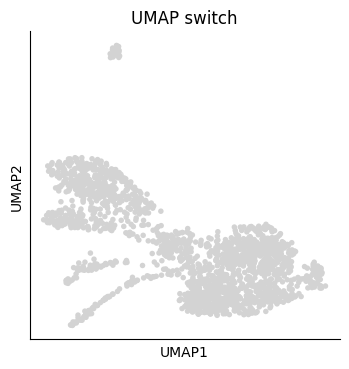

In [65]:
sc.pp.neighbors(adata_proceesed)
sc.tl.umap(adata_proceesed)
sc.pl.umap(adata_proceesed, save=f'_{REPRESENT}.png', title=f'UMAP {REPRESENT}')

### Run SEACells

In [66]:
## Core parameters
n_SEACells = 15
build_kernel_on = 'X_pca'

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells !!not sure how to tune

In [67]:
model = SEACells.core.SEACells(adata_proceesed,
                  build_kernel_on=build_kernel_on,
                  n_SEACells=n_SEACells,
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [68]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/1905 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/1905 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/1905 [00:00<?, ?it/s]

Constructing CSR matrix...


In [69]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 9 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 16/16 [00:00<00:00, 462.34it/s]

Selecting 6 cells from greedy initialization.


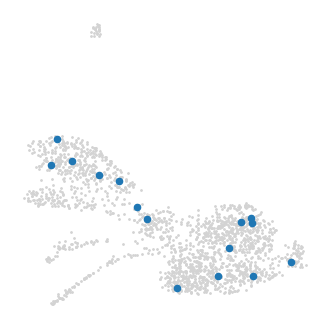

In [70]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(adata_proceesed, model)

In [71]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00078
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 23 iterations.


### Assessing results

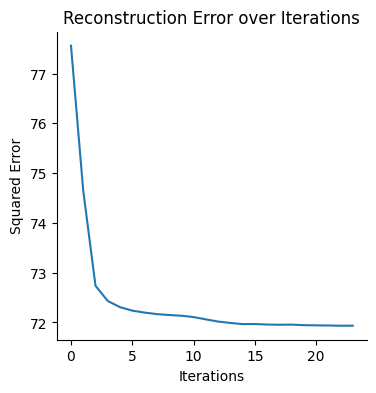

In [72]:
# Check for convergence
model.plot_convergence()

In [73]:
model.get_hard_assignments().head()

,SEACell
index,
AAACCCAAGCAGCACA-1,SEACell-3
AAACGAAAGACCGTTT-1,SEACell-9
AAACGAAAGGGCGAAG-1,SEACell-10
AAACGCTTCCTCGCAT-1,SEACell-1
AAAGAACAGGGAGGAC-1,SEACell-6


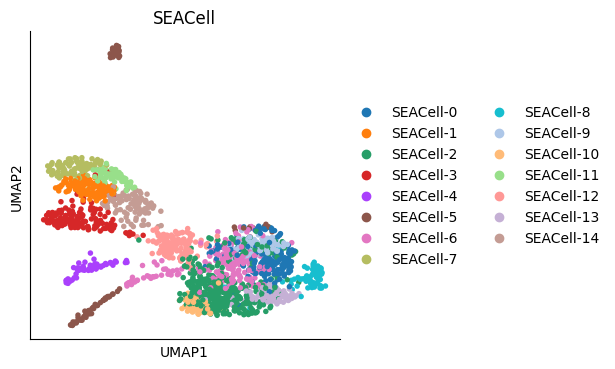

In [74]:
sc.pl.umap(adata_proceesed, color='SEACell', save=f'_SEACells_{REPRESENT}.png')

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)
/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


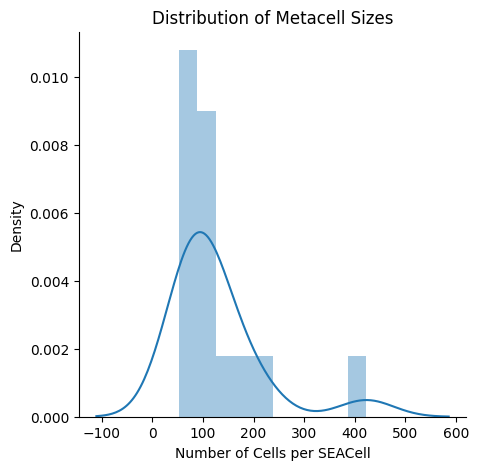

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:131: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pd.DataFrame(label_df.groupby('SEACell').count().iloc[:, 0]).rename(columns={'index':'size'})


,size
SEACell,
SEACell-0,181
SEACell-1,126
SEACell-2,423
SEACell-3,136
SEACell-4,56
SEACell-5,85
SEACell-6,211
SEACell-7,81
SEACell-8,68


In [75]:
SEACells.plot.plot_SEACell_sizes(adata_proceesed, bins=10)

# Saving Results

In [76]:
model.get_hard_assignments().to_csv(save_dir + f'SEACell_assignments_{REPRESENT}.csv', sep='\t')